# Install and Import Dependencies


In [1]:
#import libraries
import pandas as pd
import numpy as np
import warnings;
warnings.simplefilter("ignore")
from fbprophet import Prophet
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from datetime import datetime

Importing plotly failed. Interactive plots will not work.


# Read in Data and Process Data

In [3]:
# download Data
df = pd.read_excel("Case_License_Volume_2021-08-03_06-41-28-Copy1.xlsx", sheet_name="Data")

# set dtypes
df["Period"] = pd.to_datetime(df.Period)


df = df[df.Period != "2021-08-01"]
#in case the dates are seperated we can merge them together with the lower mentioned function:
#pd.DatetimeIndex(df[" "] +"-"+df[" "])

df = df.dropna(how="any")


### Case Count Prediction

#### Data Preparations

In [4]:
#lets rename the columns for the Prophet. In this case we call case count as y
df.rename(columns= {"Period": "ds", "Case Count": "y"}, inplace= True )

#we group the AG and Period as a sum to get the distinctive variables and avoid duplicates.
#here we create grouped Date Frame with out any index, in order to manipulate with AG and period later on.
df = df.groupby(["Application Group", "ds",], as_index = False).sum()

#to assign application groups to certain index we group them by App Gr.
df["Index"] = df.groupby(["Application Group"]).ngroup()


# df.to_excel("Data.xlsx")

In [6]:
lst = []
for i in range(0, 24):
    filt = df["Index"] == i
    model = df.loc[filt,["ds", "y"]]
    m = [len(model)]
    lst = lst + m
print("Maximum of Datapoints:", max(lst),"\nApplication Name:", df.loc[filt,["Application Group"]].iloc[0,0], 
      "\nApplication Number:", i)

Maximum of Datapoints: 10 
Application Name: UOM 
Application Number: 23


## Programm that runs through the multiple time series and makes a prediction

In [41]:
from functools import reduce
def Iterate(df):
    dfs = []
    for n in range(0, 25):

        #create data frame
        filt = df["Index"] == n

        model = "({0},{1})".format("model", n) 
        model = df.loc[filt,["ds", "y"]]

        #create fit
        try:
            m = "({0},{1})".format("m", n) 
            m = Prophet(interval_width=0.95)
            model = m.fit(model)

        except ValueError:
            continue

        #create forecast
        future = "({0},{1})".format("future", n)
#         future = m.make_future_dataframe(periods=8, freq='M')
        future = pd.date_range("2021-08-01",  freq = "MS", periods = 2) #how many months to forecast
        future = pd.DataFrame(future)
        future.columns = ["ds"]
        future["ds"] = pd.to_datetime(future["ds"])

        forecast = "({0},{1})".format("forecast", n)
        forecast = m.predict(future)
        forecast = forecast[["ds", "yhat"]]
        model = df.loc[filt,["ds", "y"]]
        model.columns = forecast.columns
        model = pd.concat([model, forecast], axis=0)
        
        # merge together the results
        dfs.append(model)
        
    
        
        

    #merge on one column
#     df_final = reduce(lambda how: pd.merge(how='outer'), dfs)
    df_final = reduce(lambda left,right: pd.merge(left,right,how="outer"), dfs)
    #pull out excel file and make a dashboard in excel
    df_final.to_excel("Results.xlsx")
    return df_final
df_final = Iterate(df)    


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

PermissionError: [Errno 13] Permission denied: 'Results.xlsx'

In [36]:
df_final

,ds,yhat
0,2020-12-01,0.500000
1,2021-01-01,1.700000
2,2021-02-01,14.800000
3,2021-03-01,6.100000
4,2021-04-01,6.650000
...,...,...
264,2021-05-01,7007.200000
265,2021-06-01,9773.000000
266,2021-07-01,10899.400000
267,2021-08-01,11570.833556


#### model_0 

After Data Preperations we can built first model for the 1st Application

In [47]:
#our filter is App Gr "ACESFW" which has index 0
filt = df["Index"] == 0
model_0 = df.loc[filt,["ds", "y"]]
model_0


,ds,y
0,2020-12-01,0.50
1,2021-01-01,1.70
2,2021-02-01,14.80
3,2021-03-01,6.10
4,2021-04-01,6.65
5,2021-05-01,5.05
6,2021-06-01,13.15
7,2021-07-01,23.00


# Train Model

#### train_model_0

In [51]:
#building Ml Model - PROPHET


m = Prophet(interval_width=0.95, weekly_seasonality = True)
m.fit(model_0)
#red sign indicates that there are too little variables

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


# Forecast Away

<AxesSubplot:>

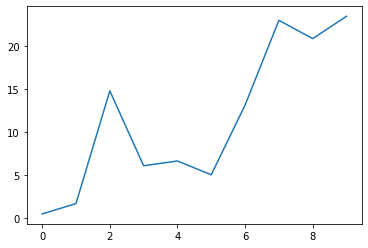

In [52]:

# future0 = m.make_future_dataframe(periods=5, freq='M')
future0 = pd.date_range("2021-08-01",  freq = "MS", periods = 2)
future0 = pd.DataFrame(future0)
future0.columns = ["ds"]
future0["ds"] = pd.to_datetime(future0["ds"])
forecast0 = m.predict(future0)

forecast0[["ds", "yhat"]]
forecast = forecast0[["ds", "yhat"]]
# plt.plot(forecast0["yhat"])
# plt.plot(model_0["y"])
s = pd.DataFrame(np.concatenate((model_0, forecast),axis =0 ))
s.columns = [ 'ds', "y"]
s
s["y"].plot()

In [157]:
#append
# s = pd.DataFrame(np.concatenate((model_0, forecast),axis =0 ))
# s.columns = [ 'ds', "y"]
# s

,ds,y
0,2020-12-01,0.5
1,2021-01-01,1.7
2,2021-02-01,14.8
3,2021-03-01,6.1
4,2021-04-01,6.65
5,2021-05-01,5.05
6,2021-06-01,13.15
7,2021-07-01,23.0
8,2021-08-01,18.828211
9,2021-09-01,21.094184


In [297]:
model_0.columns = forecast.columns
model = pd.concat([model_0, forecast, ], axis = 0)
model = model.squeeze()
type(model)


pandas.core.frame.DataFrame

### train_model_1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


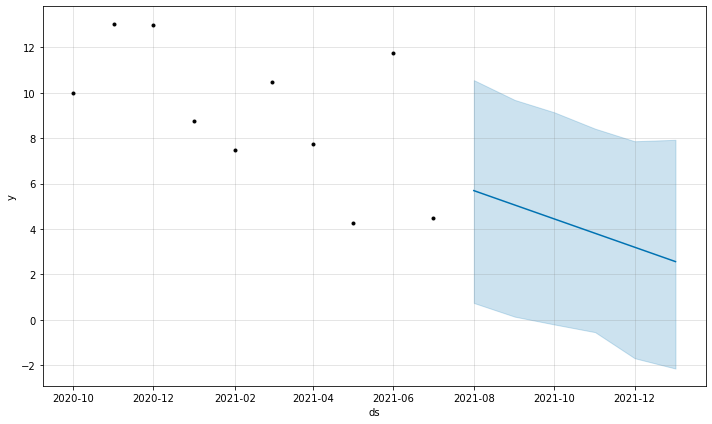

In [170]:
filt1 = df["Index"] == 1
model_1 = df.loc[filt1,["ds", "y"]]

m1 = Prophet(interval_width=0.95, weekly_seasonality=False)
model1 = m1.fit(model_1)
# future1 = m1.make_future_dataframe(periods=13, freq='M')
future1 = pd.date_range("2021-08-01",  freq = "MS", periods = 6)
future1 = pd.DataFrame(future1)
future1.columns = ["ds"]
future1["ds"] = pd.to_datetime(future1["ds"])
forecast1 = m.predict(future1)
forecast1 = m1.predict(future1)
m1.plot(forecast1)
forecast1  = forecast1[["ds", "yhat"]]


### train_model_2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


,ds,yhat
0,2020-10-01,770968.128008
1,2020-11-01,735417.620307
2,2020-12-01,701013.903294
3,2021-01-01,665463.395480
4,2021-02-01,629912.887411
5,2021-03-01,597802.751042
6,2021-04-01,562252.242735
7,2021-05-01,527848.525172
8,2021-06-01,492298.123496
9,2021-07-01,457894.508971


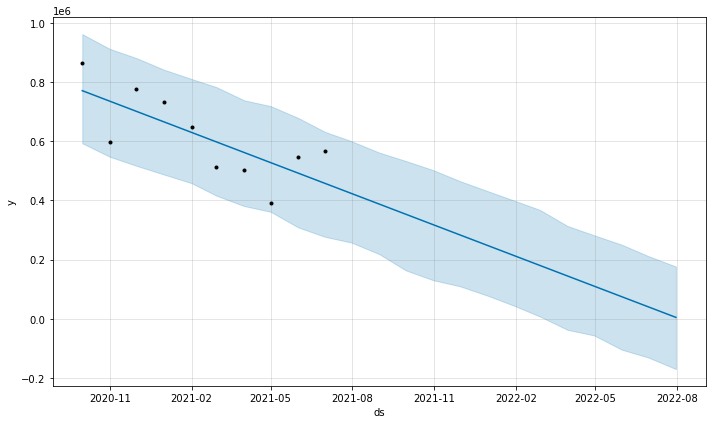

In [54]:
filt2 = df["Index"] == 2
model_2 = df.loc[filt2,["ds", "y"]]

result = adfuller(model_2["y"])



m2 = Prophet(interval_width=0.95, weekly_seasonality=False)
model2 = m2.fit(model_2)
future2 = m2.make_future_dataframe(periods=13, freq='M')
forecast2 = m2.predict(future2)
m2.plot(forecast2)
forecast2[["ds", "yhat"]]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


,ds,yhat
0,2020-10-01,4.153678
1,2020-11-01,3.751380
2,2020-12-01,2.838782
3,2021-01-01,2.700842
4,2021-02-01,3.661242
5,2021-03-01,3.687749
6,2021-04-01,4.325978
7,2021-05-01,4.044989
8,2021-06-01,3.011082
9,2021-07-01,4.412127


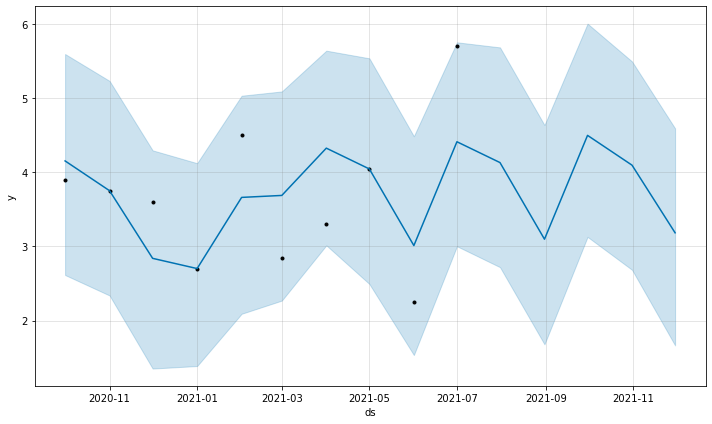

In [28]:
filt3 = df["Index"] == 3
model_3 = df.loc[filt3,["ds", "y"]]
m3 = Prophet(interval_width=0.95, weekly_seasonality=True)
model3 = m3.fit(model_3)
future3 = m3.make_future_dataframe(periods=5, freq='M')
forecast3 = m3.predict(future3)

m3.plot(forecast3)
forecast3[["ds", "yhat"]]

In [ ]:
#pull out excel file and make a dashboard in excel
df_final.to_excel("Results.xlsx")